In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation

In [8]:
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date))
latest = dt.date.fromisoformat((max_date.first()[0]))
year_from_latest = latest - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
q = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= latest).filter(Measurement.date >= year_from_latest).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(q).set_index('date')

# Sort the dataframe by date
data = data.sort_index()

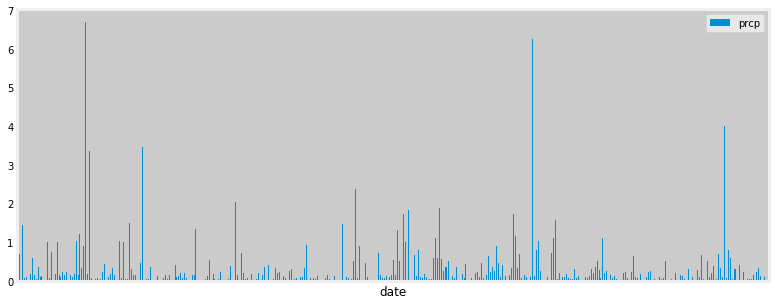

In [9]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams["figure.figsize"] = [12, 5]
data[data['prcp']>0].plot.bar()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset
session.query(Measurement.station).distinct().count()

9

In [12]:
# What are the most active stations? (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### Temperature 

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
q1 = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date <= latest).filter(Measurement.date >= year_from_latest).all()

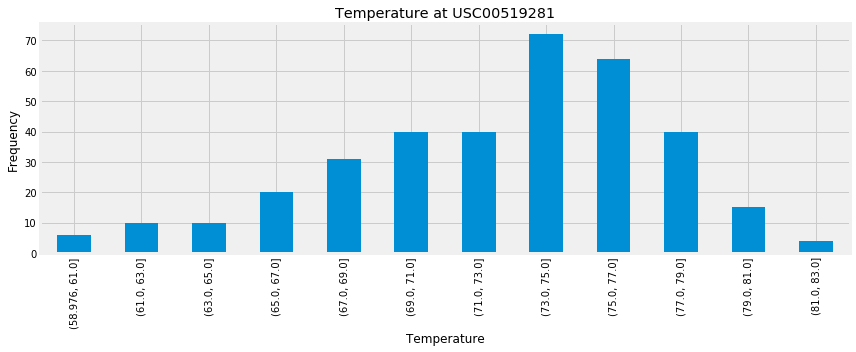

In [15]:
# Plot the results as a histogram
df = pd.DataFrame(q1)
plt.rcParams["figure.figsize"] = [12, 5]
binned = pd.cut(df['tobs'], bins=12)
labels= list(range(55,85,5))
binned.value_counts().sort_index().plot.bar()
plt.title("Temperature at USC00519281")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#print(calc_temps('2011-02-28', '2011-03-05'))
trip_temp = calc_temps('2017-02-28', '2017-03-05')
print(trip_temp)

[(64.0, 72.02777777777777, 78.0)]


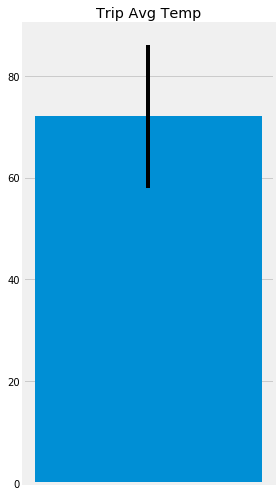

In [18]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.rcParams["figure.figsize"] = [4, 7]
plt.bar(x=1, height=[trip_temp[0][1]], yerr = trip_temp[0][2]-trip_temp[0][0])
plt.xticks([0,])
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
session.query(Measurement.station, func.sum(Measurement.prcp)).\
    filter(Measurement.date <= latest).filter(Measurement.date >= year_from_latest).\
    group_by(Measurement.station).order_by(desc(func.sum(Measurement.prcp))).all()

[('USC00516128', 147.81000000000006),
 ('USC00519281', 70.03000000000003),
 ('USC00513117', 48.510000000000026),
 ('USC00519523', 38.01),
 ('USC00514830', 33.239999999999995),
 ('USC00519397', 16.089999999999986),
 ('USC00517948', 4.59)]